# Imports

In [11]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# Data

In [2]:
df = pd.read_csv("Data/MicrosoftStock.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")  # important !
df = df.reset_index(drop=True)

print(df.head())

    index       date   open   high    low  close    volume  Name
0  390198 2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199 2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200 2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201 2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202 2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1259 non-null   int64         
 1   date    1259 non-null   datetime64[ns]
 2   open    1259 non-null   float64       
 3   high    1259 non-null   float64       
 4   low     1259 non-null   float64       
 5   close   1259 non-null   float64       
 6   volume  1259 non-null   int64         
 7   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 78.8+ KB
None
               index                           date         open         high  \
count    1259.000000                           1259  1259.000000  1259.000000   
mean   390827.000000  2015-08-09 05:44:16.393963264    51.026394    51.436007   
min    390198.000000            2013-02-08 00:00:00    27.350000    27.600000   
25%    390512.500000            2014-05-10 

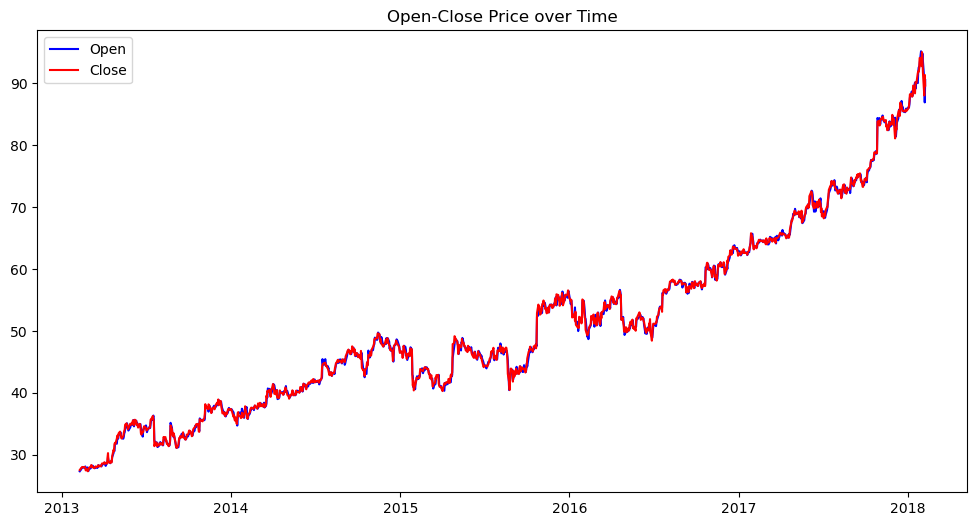

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['open'], label="Open",color="blue")
plt.plot(df['date'], df['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
# plt.show()

# Model

In [7]:
# Prepare for the LSTM Model (Sequential)
stock_close = df.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.80))
# Preprocessing Stages : rescale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
training_data = scaled_data[:training_data_len] #80% of all out data
training_data.shape

(1008, 1)

In [9]:
X_train, y_train = [], []

# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
# Reshape the input to the required sample_size x time_steps x features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(948, 60)


(948, 60, 1)

In [10]:
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

In [12]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam",
    loss="mae",
    metrics=['RootMeanSquaredError'])

2025-11-16 11:45:33.332519: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-16 11:45:33.332552: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-16 11:45:33.332562: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-11-16 11:45:33.332582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-16 11:45:33.332596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/dl_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
h = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


2025-11-16 11:45:44.673542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - RootMeanSquaredError: 0.2664 - loss: 0.1855
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1357 - loss: 0.1045
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1183 - loss: 0.0900
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1176 - loss: 0.0893
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1165 - loss: 0.0862
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1153 - loss: 0.0871
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1050 - loss: 0.0796
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1118 - loss: 0.0845
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - RootMeanSquaredError: 0.1033 - loss: 0.0790
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - RootMeanSquaredError: 0.1055 - loss: 0.0792
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1

In [14]:
predictions = model.predict(X_test)
print(predictions[:2])
predictions = scaler.inverse_transform(predictions) 

print(predictions[:2])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.81091505]
 [0.824419  ]]
[[63.1021  ]
 [63.302586]]


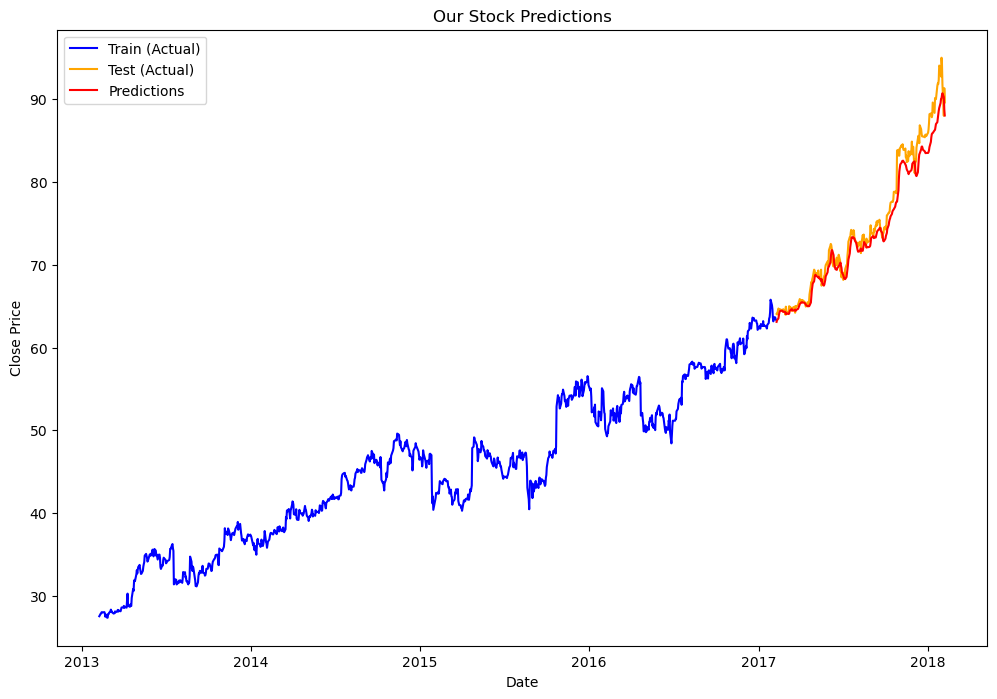

In [15]:
train = df[:training_data_len]
test = df[training_data_len:]
test = test.copy()
test['Predictions'] = predictions
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()